In [2]:
# Setting Up the Programming Environment

# handling www based requests (like APIs)
import urllib as ul

# standard Python data handling modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

# working with networks
import networkx as nx

# working with gene set enrichment analysis (GSEA)
import gseapy as gp

For Step1 you can either use the fully automated approcah using Steps 1a, and 1b, or working from files you generate from the KEGG and String-DB websites as described in Step 1c.

In [35]:
# need to pull in the gene lists here
geneSymbols = pd.read_csv('../networks/gene_symbols.csv')

geneSymbols.head()

,gene_symbol
0,A1BG
1,A1BG-AS1
2,A2M
3,A2M-AS1
4,A2ML1


In [43]:
'''
As the STRING API isn't really designed to deal with genome scale calls we have downloaded the entire protein interaction dataset
for human and the mapping file that STRING use to map other gene identiers to their internal identifiers.

https://string-db.org/cgi/download

We will use pandas merge functions to map the HGNC gene symbols to the corresponding STRING identifiers.
'''

# read in the interactions file
interactions = pd.read_csv('../networks/9606.protein.links.full.v12.0.txt', sep=' ')

# read in the mapping file
# mapping = pd.read_csv('../networks/9606.protein.aliases.v12.0.HGNC.txt', sep='\t', header=None)
mapping = pd.read_csv('../networks/9606.protein.aliases.v12.0.txt', sep='\t', header=None)
#put in place column headings
mapping.columns = ['stringID', 'alias', 'source']


In [44]:
interactions.head()

,protein1,protein2,neighborhood,neighborhood_transferred,fusion,cooccurence,homology,coexpression,coexpression_transferred,experiments,experiments_transferred,database,database_transferred,textmining,textmining_transferred,combined_score
0,9606.ENSP00000000233,9606.ENSP00000356607,0,0,0,0,0,0,45,0,134,0,0,0,81,173
1,9606.ENSP00000000233,9606.ENSP00000427567,0,0,0,0,0,0,0,0,128,0,0,0,70,154
2,9606.ENSP00000000233,9606.ENSP00000253413,0,0,0,0,0,49,111,0,49,0,0,0,69,151
3,9606.ENSP00000000233,9606.ENSP00000493357,0,0,0,0,0,56,0,0,53,0,0,433,81,471
4,9606.ENSP00000000233,9606.ENSP00000324127,0,0,0,0,0,0,0,0,46,0,0,153,91,201


In [45]:
mapping.head()

,stringID,alias,source
0,#string_protein_id,alias,source
1,9606.ENSP00000000233,2B6H,Ensembl_PDB
2,9606.ENSP00000000233,2B6H,UniProt_DR_PDB
3,9606.ENSP00000000233,381,Ensembl_HGNC_entrez_id
4,9606.ENSP00000000233,381,KEGG_GENEID


In [46]:
# merge the geneSymbols with the mapping file on the gene_symbol column in the former and the alias in the latter
mappedGenes = geneSymbols.merge(mapping, left_on='gene_symbol', right_on='alias')

mappedGenes.head()


,gene_symbol,stringID,alias,source
0,A1BG,9606.ENSP00000263100,A1BG,BioMart_HUGO
1,A1BG,9606.ENSP00000263100,A1BG,Ensembl_EntrezGene
2,A1BG,9606.ENSP00000263100,A1BG,Ensembl_HGNC
3,A1BG,9606.ENSP00000263100,A1BG,Ensembl_HGNC_symbol
4,A1BG,9606.ENSP00000263100,A1BG,Ensembl_UniProt


In [47]:

# only retain the gene_symbol and stringID columns and make the rows unique
mappedGenes = mappedGenes[['gene_symbol', 'stringID']].drop_duplicates()

# print the length of the geneSymbols dataframe
print(len(mappedGenes))

mappedGenes.head()

'''
It's important to understand how successful mappings are so we need to look at where these have failed.
'''

# calulate the proportion of unique gene symbols that have been mapped
print(len(mappedGenes)/len(geneSymbols))

# we have lost some genes so we need to understand why
# find the gene symbols that are in geneSymbols but not in mappedGenes
missing = geneSymbols[~geneSymbols.gene_symbol.isin(mappedGenes.gene_symbol)]

missing.head()

16974
0.7505637850983861


,gene_symbol
1,A1BG-AS1
3,A2M-AS1
5,A2MP1
9,AACSP1
11,AADACP1


In [49]:
# now we're going to use the unqiue list of string Ids from above and find every interaction where both partners are in the list
# we need to remember that we need to catch both a>b and b>a interactions

# get the unique list of string IDs
uniqueStrings = mappedGenes.stringID.unique()

# filter the interactions dataframe to only include rows where the protein1 and protein2 columns are in the uniqueStrings list
filteredInteractions = interactions[interactions.protein1.isin(uniqueStrings) & interactions.protein2.isin(uniqueStrings)]

# print the length of the filteredInteractions dataframe
print(len(filteredInteractions))

filteredInteractions.head()

11247934


,protein1,protein2,neighborhood,neighborhood_transferred,fusion,cooccurence,homology,coexpression,coexpression_transferred,experiments,experiments_transferred,database,database_transferred,textmining,textmining_transferred,combined_score
0,9606.ENSP00000000233,9606.ENSP00000356607,0,0,0,0,0,0,45,0,134,0,0,0,81,173
1,9606.ENSP00000000233,9606.ENSP00000427567,0,0,0,0,0,0,0,0,128,0,0,0,70,154
2,9606.ENSP00000000233,9606.ENSP00000253413,0,0,0,0,0,49,111,0,49,0,0,0,69,151
3,9606.ENSP00000000233,9606.ENSP00000493357,0,0,0,0,0,56,0,0,53,0,0,433,81,471
4,9606.ENSP00000000233,9606.ENSP00000324127,0,0,0,0,0,0,0,0,46,0,0,153,91,201


/home/ian/miniconda3/envs/ismb24/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


150
999


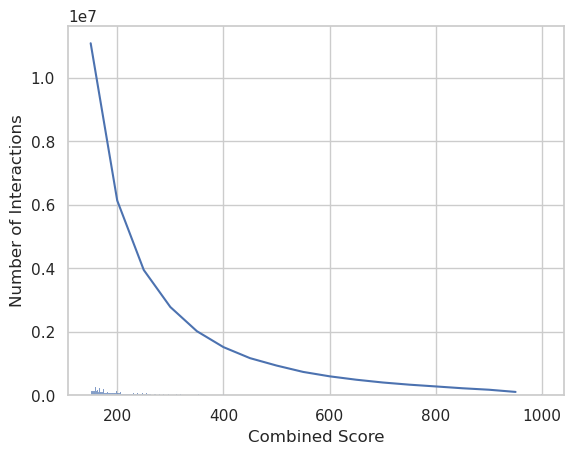

In [62]:
#lets take a look at a histogram of the combined score using seaborn
import seaborn as sns
sns.set_theme(style="whitegrid")
ax = sns.histplot(filteredInteractions.combined_score, kde=False)

#report the min/max of the combined score
print(filteredInteractions.combined_score.min())
print(filteredInteractions.combined_score.max())

# create a plot using seaborn where we vary the cut-off for the combined score on the x-axis and the number of interactions that pass that cut-off on the y-axis

# generate the x-axis values
x = [i for i in range(150, 1000, 50)]
y = [len(filteredInteractions[filteredInteractions.combined_score > i]) for i in x]

# create the plot
plt.plot(x, y)
plt.xlabel('Combined Score')
plt.ylabel('Number of Interactions')
plt.show()



In [79]:
# find the inflection point of the above curve
# we can see that the curve is relatively flat until a combined score of 400
# we will use this as our cut-off
cutoff = 800

# filter the interactions dataframe to only include rows where the combined_score column is greater than the cutoff
filteredInteractions = filteredInteractions[filteredInteractions.combined_score > cutoff]

# print the length of the filteredInteractions dataframe
print(len(filteredInteractions))

filteredInteractions.head()

277386


,protein1,protein2,neighborhood,neighborhood_transferred,fusion,cooccurence,homology,coexpression,coexpression_transferred,experiments,experiments_transferred,database,database_transferred,textmining,textmining_transferred,combined_score
85,9606.ENSP00000000233,9606.ENSP00000158762,0,0,0,0,0,47,0,0,91,0,0,804,91,825
160,9606.ENSP00000000233,9606.ENSP00000262305,0,0,0,0,0,0,0,625,139,0,0,865,46,952
489,9606.ENSP00000000233,9606.ENSP00000480301,0,0,0,0,0,49,0,0,62,0,0,828,52,835
533,9606.ENSP00000000233,9606.ENSP00000249923,0,0,0,0,0,56,124,0,157,500,0,573,166,846
546,9606.ENSP00000000233,9606.ENSP00000306010,0,0,0,0,983,49,0,780,0,500,0,57,0,888


##### <font color='darkblue'>Retrieval of Protein-Protein Interactions from STRING</font>

The details of the String-DB API can be found here - [https://string-db.org/help/api/](https://string-db.org/help/api/)

APIs have specific formats required for their query URLs and it getting these correct in your code can take a little time until you get used to them. In this case we need to concatenate (stitch together) our gene IDs using a '%0D' string. This is actually the encoding for a line-return which is in effect mimicking the one gene per line entry that you would paste into the web page.

##### <font color='darkblue'>Generating the Protein-Protein Interaction Network</font>

Next we are going to use the NetworkX Python library to create the protein-protein interaction network.

NetworkX - Network Analysis in Python - [https://networkx.org/documentation/stable/index.html](https://networkx.org/documentation/stable/index.html)

In [80]:
# create a simple network view of the interactions using the NetworkX library
# https://networkx.org/documentation/stable/index.html

import networkx as nx
import matplotlib.pyplot as plt

 #Create an empty graph
G = nx.Graph()

# add all nodes
G.add_nodes_from(set(filteredInteractions['protein1']) | set(filteredInteractions['protein2'])) 

# add the edges (connections) to the network
edges = []
for edge1 , edge2  in zip(filteredInteractions['protein1'] , filteredInteractions['protein2']) : #add all edge to the network
    edges.append((edge1 , edge2 ))
G.add_edges_from(edges)

#save the graph in gml format
nx.write_gml(G,"smokingPPI.gml")

# export the graph as a list of edges
nx.write_edgelist(G, "smokingPPIedgelist.csv", delimiter=',')

# # draw the network with a force directed layout specify plot size and node size and thin light gray edges
# plt.figure(figsize=(15,15))
# nx.draw(G, pos=nx.spring_layout(G,k=2), with_labels=True,node_size=100,edge_color='gray',node_color='lightblue',width=0.5)

##### <font color='darkblue'>Node Degree</font>

Node degree is simply the number of connections a node has. Nodes with higher degree are often called `hub` nodes because they have many connections to other members of the network.

In [81]:
print(nx.density(G)*100)

0.1775980724091977


In [ ]:
#sort the genes (node names) by degree
sorted_list = sorted(G.degree(), key=lambda item: item[1] , reverse=True)

# print out the top10 using prettytable
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Gene","Degree"]
for gene in sorted_list[:10]:
    x.add_row(gene)
print(x)

##### <font color='darkblue'>Closeness Centrality</font>
This is a measure of how close a node is to the centre of the network. The closer a node is to the centre the shorter its path to all other nodes and hence its more likely to be representative of the network

In [ ]:
# sort the genes (node names) by proximity to center
sorted_list = sorted(nx.closeness_centrality(G).items(), key=lambda item: item[1] , reverse=True) 

# print out the top10 using prettytable
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Gene","Closeness"]
for gene in sorted_list[:10]:
    x.add_row(gene)
print(x)

##### <font color='darkblue'>Clustering Coefficient</font>
The clustering coefficient is a measure which combines centrality and degree. It measures the number of triangles a node can form ('the friend of my friend is my friend'). If a node has more common friends with other nodes it more likely to representative of the network

In [ ]:
# sort the genes (node names) by clustering coefficient
sorted_list = sorted(nx.clustering(G).items(), key=lambda item: item[1] , reverse=True)

# print out the top10 using prettytable
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Gene","Clustering"]
for gene in sorted_list[:10]:
    x.add_row(gene)
print(x)

##### <font color='darkblue'>Clustering the Network</font>

In [ ]:
import networkx as nx
from prettytable import PrettyTable

# we're going to cluster the networkx modularity clustering algorithm
communities = nx.algorithms.community.modularity_max.greedy_modularity_communities(G)

# print the number of communities
print('The network has '+str(len(communities))+' communities.\n')

# create sub-grpahs for each community
subgraphs = []
for community in communities:
    subgraphs.append(G.subgraph(community))
    
# print the number of nodes in each community
for i, subgraph in enumerate(subgraphs):
    print('Community '+str(i+1)+' has '+str(subgraph.number_of_nodes())+' nodes.')

##### <font color='darkblue'>Plot the Graph with Clusters Coloured</font>

In [ ]:
# create a dict with the gene_id as key and community membership list as value
communityDict = dict()

# loop through the communities
for i, community in enumerate(communities):
    # loop through the diseases in the community
    for gene_id in community:
        # add the disease and community to the dictionary
        communityDict[gene_id] = i

# plot the graph with the communities coloured
# create a list of 18 colors
communityColours = ['#1f77b4','#ff7f0e','#2ca02c']

# create a list of the node colours
nodeColours = [communityColours[communityDict[node]] for node in G.nodes()]

# create a list of the node labels
nodeLabels = {node:node for node in G.nodes()}

# plot the graph
import matplotlib.pyplot as plt

# set the figure size
plt.figure(figsize=(20,20))

# draw the graph separating nodes by their community

pos = nx.spring_layout(G, k=0.2, iterations=30, scale=1.5)
nx.draw(G, pos, node_color=nodeColours, with_labels=True, node_size=1000, font_size=12, width=0.5)

In [ ]:
# use enrichr to perform gene set enrichment analysis on the communities

#create a separate gene list from communityDict dictionary for each community
community1_genes = []
community2_genes = []
community3_genes = []

# loop through the dictionary
for gene_id, community in communityDict.items():
    # add the gene to the appropriate community list
    if community == 0:
        community1_genes.append(gene_id)
    elif community == 1:
        community2_genes.append(gene_id)
    elif community == 2:
        community3_genes.append(gene_id)

def communityORA(genes):
    # perform ORA against the Hallmark gene sets for each community
    enr = gp.enrichr(gene_list=genes, # perform enrichment analysis using gsea
                    gene_sets=['MSigDB_Hallmark_2020'],
                    organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                    outdir=None, # don't write to disk
                    )
    return enr

# perform ORA for each community
community1_enr = communityORA(community1_genes)
community2_enr = communityORA(community2_genes)
community3_enr = communityORA(community3_genes)

# print the top 10 results for each community using prettytable
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Community 1","Community 2","Community 3"]
for i in range(10):
    x.add_row([community1_enr.results['Term'][i],community2_enr.results['Term'][i],community3_enr.results['Term'][i]])
print(x)

##### <font color='darkblue'>Gene Set Enrichement Analysis Example</font>

In order to perform [GSEApy](https://gseapy.readthedocs.io/en/latest/index.html) we are going to use some suitable data. In this case some gene expression measurements for Parkinson's Disease from:

- Lewandowski NM et al.Polyamine pathway contributes to the pathogenesis of Parkinson disease.
- Proc Natl Acad Sci U S A. 2010 Sep 28;107(39):16970-5. [doi: 10.1073/pnas.1011751107](https://doi.org/10.1073/pnas.1011751107).

In [ ]:
# Note this is crude as we are simply using normalised gene expression values, not for example performing differential gene expression analysis
# we will return to this data in the coming weeks when we look at how we analyse gene expression data to find potentially important genes

# we first read in the gene expression data which was measured from people with Parkinson's disease and healthy controls
genExp = pd.read_csv('../data/expression/PD_Expr.tsv',sep='\t',header=0,index_col=False)

# # select rows where 'IDENTIFIER' is in the gene_ids list
# genExp = genExp.loc[genExp['IDENTIFIER'].isin(gene_symbols)]

# change column names 'ID_Ref' to 'Name' and 'IDENTIFIER' to 'GENES'
genExp = genExp.rename(columns={'ID_REF':'NAME','IDENTIFIER':'GENES'})

# drop the 'NAME' column
genExp = genExp.drop(labels='NAME',axis=1)

#make the GENES column the index
genExp = genExp.set_index('GENES')

# how big is the dataframe
print('The dataframe has '+str(genExp.shape[0])+' rows and '+str(genExp.shape[1])+' columns.\n')

# show the top of the dataframe
genExp.head()

In [ ]:
# we next need to specify which columns (samples are from PD patients and which are from controls)

control = ['GSM488132','GSM488118','GSM488116','GSM488114','GSM488112','GSM488131','GSM488117','GSM488115','GSM488113','GSM488111']
parkinsons = ['GSM488130','GSM488128','GSM488126','GSM488124','GSM488122','GSM488120','GSM488129','GSM488127','GSM488125','GSM488123','GSM488121','GSM488119']

# create a class list where the class is 'control' if the sample is in the control list and 'pd' if it is in the pd list
classes = []
for sample in genExp.columns:
    if sample in control:
        classes.append('control')
    elif sample in parkinsons:
        classes.append('parkinsons')
    else:
        pass

# print the number of samples in each class
print('There are '+str(classes.count('control'))+' control samples and '+str(classes.count('parkinsons'))+' PD samples.\n')

print(classes)

In [ ]:
# perform GSEA for each community against the union of the other commmunites

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

# #list the available MSigDB libraries
# libraries = gp.get_library_name()

# #pick a random library from libraries using random.choice
# gene_sets = np.random.choice(libraries)

# #print the library name
# print('The library we will use is '+gene_sets)

gene_sets = 'KEGG_2019_Human'

#perform GSEA
gs_res = gp.gsea(data=genExp,
                 gene_sets=gene_sets,
                 cls= classes,
                 permutation_num=100,
                 outdir=None,
                 method='signal_to_noise',
                 threads=4, seed= 7)

gs_res.res2d.head()

In [ ]:
# plot the GSEA curves
terms = gs_res.res2d.Term
axs = gs_res.plot(terms[:5], show_ranking=False, legend_kws={'loc': (1.05, 0)}, )

In [ ]:
from gseapy import heatmap
# plotting heatmap
i = 2
genes = gs_res.res2d.Lead_genes[i].split(";")
# Make sure that ``ofname`` is not None, if you want to save your figure to disk
ax = heatmap(df = gs_res.heatmat.loc[genes], z_score=0, title=terms[i], figsize=(14,4))
# label the x axis with the class label of the sample
ax.set_xticklabels(classes,rotation=45,ha='right')
ax.plot()

In [ ]:
from seaborn import clustermap
# clustermap
i = 2
genes = gs_res.res2d.Lead_genes[i].split(";")
# Make sure that ``ofname`` is not None, if you want to save your figure to disk
# ax = clustermap(data = gs_res.heatmat.loc[genes], z_score=0, figsize=(14,4),metric='correlation',method='average')
ax = clustermap(
    data = gs_res.heatmat.loc[genes],
    pivot_kws=None,
    method='average',
    metric='euclidean',
    z_score=0,
    figsize=(14, 4),
    dendrogram_ratio=0.2,
    colors_ratio=0.03,
    cbar_pos=(0.02, 0.1, 0.05, 0.1),
    tree_kws=None)

# label the x axis with the class label of the sample
ax.ax_heatmap.set_xticklabels(classes,rotation=45,ha='right');

In [ ]:
from gseapy import dotplot
# to save your figure, make sure that ``ofname`` is not None
ax = dotplot(gs_res.res2d,
             column="FDR q-val",
             title='KEGG_2021_Human',
             cmap=plt.cm.viridis,
             size=5,
             figsize=(4,5), cutoff=1)

##### <font color='darkblue'>(Optional) Using the PantherDB API for Enrichment Analysis</font>

PantherDB API details - [http://pantherdb.org/services/details.jsp](http://pantherdb.org/services/details.jsp)

Functionality and Parameter testing - [http://pantherdb.org/services/openAPISpec.jsp](http://pantherdb.org/services/openAPISpec.jsp)

This is quite hard work so you might decide it's simplest (and quicker) at this stage to use the website functionality above).

In [ ]:
# results are returned in JSON format so we need to load a Python module to handle this
import json

# the PantherDB API offers this function to find out what annotated resources it has available
query_url = 'http://pantherdb.org/services/oai/pantherdb/supportedannotdatasets'

# execute the query
result = ul.request.urlopen(query_url)

# load the results returning a Python dictionary
annotationSets = json.load(result)

annotations = annotationSets['search']['annotation_data_sets']['annotation_data_type']

# we can just iterate through these to see the annotation sources available
for i in annotations:
    print('Annotation Set Label = '+i['label']+', annotDataSet string to use below = '+i['id'])

In [ ]:
# using the list of Entrez Gene IDs generated above (entrezgene_id) create a query string for the API
# these need to be comma separated
genes = ','.join(map(str,gene_ids))

# use the PantherDB API - NB that GO:0008150 is the accession for the "Biological Process" clade of the Gene Ontology from above
query_url = "http://pantherdb.org/services/oai/pantherdb/enrich/overrep?&geneInputList="+genes+"&organism=9606&annotDataSet=GO:0008150&enrichmentTestType=FISHER&correction=FDR"

# capture the results (NB this returns in JSON format)
result = ul.request.urlopen(query_url)

# load the results from JSON to Python dictionary
enrichment_result = json.load(result)

We're now going to format that into something human readable. There are many ways to do this, but this is a quick and (fairly) simple solution. Please do feel free to try your own.

In [ ]:
# extract the actual result component
results = enrichment_result['results']['result']

# how long is the background list (in this case it is the default, the whole genome)
print(len(results), "terms in reference list")

# we're going to print this in a nice looking ASCII table
from prettytable import PrettyTable

x = PrettyTable()

x.field_names = ["GO Term", "Expected", "Fold enrichment", "raw P value", "FDR", "Term label"]

# Sort in order of false discovery rate i.e. multiple testing correction
results.sort(key=lambda x: x['fdr'], reverse=False)

# show the top10 results
for r in results[:10]:
    fdr = r['fdr']
    if fdr < 0.05:
        # Print result line
        term_id = r['term'].get("id")
        if term_id is None:
            term_id = ""
        else:
            current_row = [
                term_id,
                str('{0:.3f}'.format(r['expected'])),  # Convert float to string for printing
                str('{0:.3f}'.format(r['fold_enrichment'])),
                str('{0:.3g}'.format(r['pValue'])),
                str('{0:.3g}'.format(r['fdr'])),
                r['term']["label"]
            ]
    x.add_row(current_row)

print(x)

# that was quite painful